# Accelerated Time Failure Model

In [71]:
import numpy as np
import pandas as pd
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter, KaplanMeierFitter
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
import os

In [72]:
# Obtener la ruta absoluta del directorio actual (donde está el script o notebook)
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Subimos un nivel

# Construir la ruta relativa a la carpeta "Datos"
ruta_bdd = os.path.join(base_dir, "Datos", "database.xlsx")


In [73]:
data = pd.read_excel(ruta_bdd, sheet_name=None)

In [74]:
# Concatenamos los dataframes de cada key:
data = pd.concat(data.values(), ignore_index=True)
print(data.shape)
data.head()

(50, 20)


,FECHA,Caudal,TPH,% Solido,Presion,Bateria,Ciclón,Medicion,horometro,camino_id,uso_230,TPH_acum,dias_230,solido_uso,carga_solidos_efectiva,ratio_tph_caudal,solido_presion,score,score_out,E
0,2019-03-18,3597.082433,4411.410040,70.733724,9.834485,BHC 1011,CyA,240.0,17987.828125,1011 CyA_2018-09-03,7.769185,17645.640160,196,806.616845,3569.200270,1.226386,695.629739,0.032372,0,1
1,2024-08-18,5618.364990,4718.561523,59.569263,10.484711,BHC 1011,CyB,233.5,50149.431641,1011 CyB_2024-07-31,5.004379,9437.123047,18,992.097028,1534.345463,0.839846,624.566522,0.021432,0,0
2,2017-11-07,3670.201487,4837.450935,69.523774,9.905015,BHC 1011,CyF,235.0,13588.043945,1011 CyF_2017-09-12,7.086742,9674.901870,56,859.725387,2035.672278,1.318034,688.634014,0.030156,0,0
3,2020-06-15,3729.695813,4095.470163,69.796485,9.795065,BHC 1011,CyG,240.0,25063.132812,1011 CyG_2019-10-08,8.229440,8190.940325,251,756.237500,1511.840380,1.098071,683.661131,0.034289,0,1
4,2024-09-10,4954.049217,4812.063802,62.948331,7.701962,BHC 1011,CyG,232.5,49058.373047,1011 CyG_2024-07-31,6.147913,14436.191406,41,880.653280,2361.581207,0.971340,484.825678,0.026443,0,0


## Implementación AFT

Primero verificaremos que la distribución distinta de censuras sea (o no) aleatoria:

In [75]:
data["E"].value_counts()

E
0    26
1    24
Name: count, dtype: int64

In [76]:
from scipy.stats import ks_2samp

ks_stat, p_value = ks_2samp(data[data["E"] == 1]["dias_230"], data[data["E"] == 0]["E"])
print(f"Estadístico KS: {ks_stat:.4f}, p-valor: {p_value:.4f}")

if p_value < 0.05:
    print("Las distribuciones de censurados y no censurados son significativamente diferentes.")
else:
    print("No hay evidencia suficiente para afirmar que las distribuciones sean diferentes.")


Estadístico KS: 1.0000, p-valor: 0.0000
Las distribuciones de censurados y no censurados son significativamente diferentes.


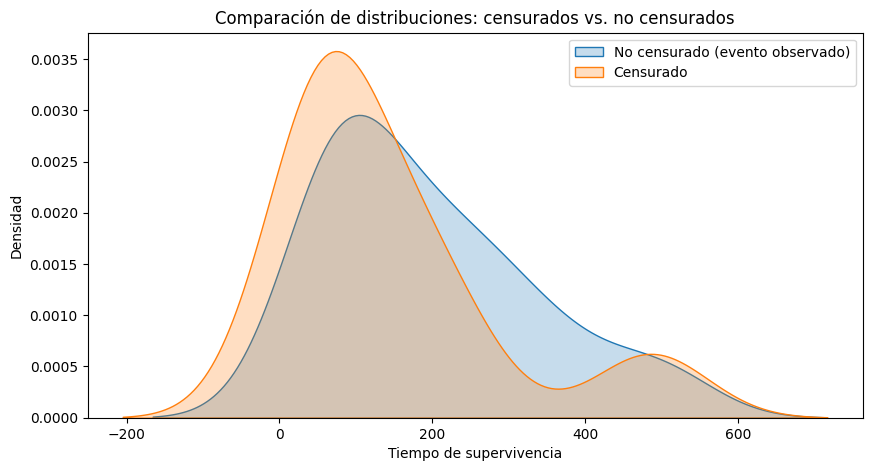

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.kdeplot(data[data["E"] == 1]["dias_230"], label="No censurado (evento observado)", fill=True)
sns.kdeplot(data[data["E"] == 0]["dias_230"], label="Censurado", fill=True)
plt.xlabel("Tiempo de supervivencia")
plt.ylabel("Densidad")
plt.title("Comparación de distribuciones: censurados vs. no censurados")
plt.legend()
plt.show()


## Medium

In [78]:
from lifelines import WeibullFitter,\
                      ExponentialFitter,\
                      LogNormalFitter,\
                      LogLogisticFitter
# Instantiate each fitter
wb = WeibullFitter()
ex = ExponentialFitter()
log = LogNormalFitter()
loglogis = LogLogisticFitter()
# Fit to data
for model in [wb, ex, log, loglogis]:
    model.fit(durations = data["dias_230"], event_observed = data["E"])
    # Print AIC
    print("The AIC value for", model.__class__.__name__, "is",  model.AIC_)

The AIC value for WeibullFitter is 326.1420138436958
The AIC value for ExponentialFitter is 331.180791415206
The AIC value for LogNormalFitter is 323.27623521693306
The AIC value for LogLogisticFitter is 325.3057783038221


In [79]:
data.columns

Index(['FECHA', 'Caudal', 'TPH', '% Solido', 'Presion', 'Bateria', 'Ciclón',
       'Medicion', 'horometro', 'camino_id', 'uso_230', 'TPH_acum', 'dias_230',
       'solido_uso', 'carga_solidos_efectiva', 'ratio_tph_caudal',
       'solido_presion', 'score', 'score_out', 'E'],
      dtype='object')

In [92]:
from lifelines import LogNormalAFTFitter, CoxPHFitter

formula_str = "uso_230 + horometro + TPH_acum"

lognorm_aft = LogNormalAFTFitter()
lognorm_aft.fit(data, duration_col='dias_230', event_col='E', formula=formula_str)
lognorm_aft.print_summary(3)

<lifelines.LogNormalAFTFitter: fitted with 50 total observations, 26 right-censored observations>
             duration col = 'dias_230'
                event col = 'E'
   number of observations = 50
number of events observed = 24
           log-likelihood = -132.702
         time fit was run = 2025-02-19 19:35:43 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                   
mu_    Intercept -1.049     0.350     0.513          -2.055          -0.043               0.128               0.958
       uso_230    0.683     1.979     0.078           0.530           0.835               1.699               2.305
       horometro  0.000     1.000     0.000           0.000           0.000               1.000               1.000
       TPH_acum   0.000     1.000     0.000           0.000           0.000               1.000               1.000
sigma_ Intercept -1.317     0.268     0.148          -1.606          -1.027               0.201               0.358

                  cmp to      z       p  -log2(p)
param  covariate                                 
mu_    Intercept   0.000 -2.044   0.041     4.609
       uso_230     0.000  8.768 <0.0005    58.934
       horometro   0.000  2.848   0.004     7.827
       TPH_acum    0.000  2.643   0.008     6.928
sigma_ Intercept   0.000 -8.924 <0.0005    60.944
---
Concordance = 0.918
AIC = 275.403
log-likelihood ratio test = 53.873 on 3 df
-log2(p) of ll-ratio test = 36.285

In [93]:
print(lognorm_aft.median_survival_time_)
print(lognorm_aft.mean_survival_time_)

149.40244399814273
154.8672339130248


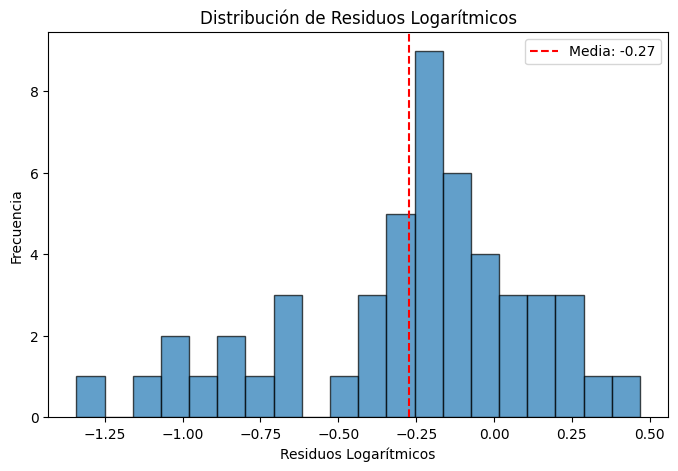

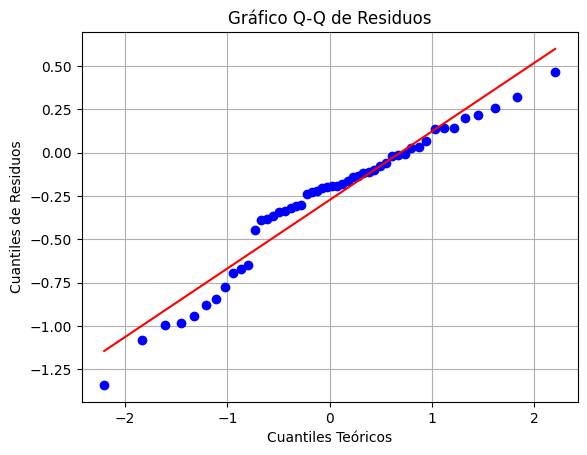


📊 Comparación de Modelos:


,Modelo,Concordance Index,AIC
0,LogNormal,0.081967,275.403025
1,Weibull,0.104508,279.759301
2,LogLogistic,0.092213,274.890700



✅ Mejor modelo según AIC: LogLogistic


In [94]:
from lifelines import LogNormalAFTFitter, WeibullAFTFitter, LogLogisticAFTFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
import scipy.stats as stats

# Suponemos que 'data' es tu DataFrame con las columnas:
# 'dias_230' (duración del evento), 'E' (evento observado: 1 = ocurrió, 0 = censurado), 'uso_230' (variable predictora)

# Ajustar el modelo LogNormal
lognormal_model = LogNormalAFTFitter()
lognormal_model.fit(data, duration_col="dias_230", event_col="E", formula=formula_str)

# -------------------------------------
# 1️⃣ Calcular residuos logarítmicos
# -------------------------------------
log_tiempo_observado = np.log(data["dias_230"])  # Aplicamos logaritmo al tiempo observado
tiempo_predicho = lognormal_model.predict_median(data)  # Predicción del modelo
log_residuos = log_tiempo_observado - np.log(tiempo_predicho)  # Residuos en escala logarítmica

# -------------------------------------
# 2️⃣ Histograma de residuos
# -------------------------------------
plt.figure(figsize=(8,5))
plt.hist(log_residuos, bins=20, edgecolor="black", alpha=0.7)
plt.axvline(log_residuos.mean(), color='red', linestyle="dashed", label=f"Media: {log_residuos.mean():.2f}")
plt.xlabel("Residuos Logarítmicos")
plt.ylabel("Frecuencia")
plt.title("Distribución de Residuos Logarítmicos")
plt.legend()
plt.show()

# -------------------------------------
# 3️⃣ Gráfico Q-Q para verificar normalidad
# -------------------------------------
stats.probplot(log_residuos, dist="norm", plot=plt)
plt.title("Gráfico Q-Q de Residuos")
plt.xlabel("Cuantiles Teóricos")
plt.ylabel("Cuantiles de Residuos")
plt.grid()
plt.show()

# -----------------------------
# 3️⃣ Ajustar modelos alternativos y comparar desempeño
# -----------------------------
modelos = {
    "LogNormal": LogNormalAFTFitter(),
    "Weibull": WeibullAFTFitter(),
    "LogLogistic": LogLogisticAFTFitter()
}

resultados = []

for nombre, modelo in modelos.items():
    modelo.fit(data, duration_col="dias_230", event_col="E", formula=formula_str)
    
    # Calcular métricas
    concordance = concordance_index(data["dias_230"], -modelo.predict_median(data), data["E"])
    aic = modelo.AIC_
    
    # Guardar resultados
    resultados.append({
        "Modelo": nombre,
        "Concordance Index": concordance,
        "AIC": aic
    })

# Convertir resultados en DataFrame
df_resultados = pd.DataFrame(resultados)
print("\n📊 Comparación de Modelos:")
display(df_resultados)

# Seleccionar el mejor modelo basado en el AIC
mejor_modelo = df_resultados.loc[df_resultados["AIC"].idxmin(), "Modelo"]
print(f"\n✅ Mejor modelo según AIC: {mejor_modelo}")


### Evaluación del modelo:

C-index en el set de prueba: 0.077

Predicción particular:
    Medicion  dias_230  E   uso_230  pred_median
30     235.0        56  0  6.547343   136.990841
19     236.0        56  0  6.939576   172.048591
26     235.0       118  0  7.522314   106.300248
17     240.0       232  1  8.040083   227.801969
13     240.0       307  1  8.490988   361.571173


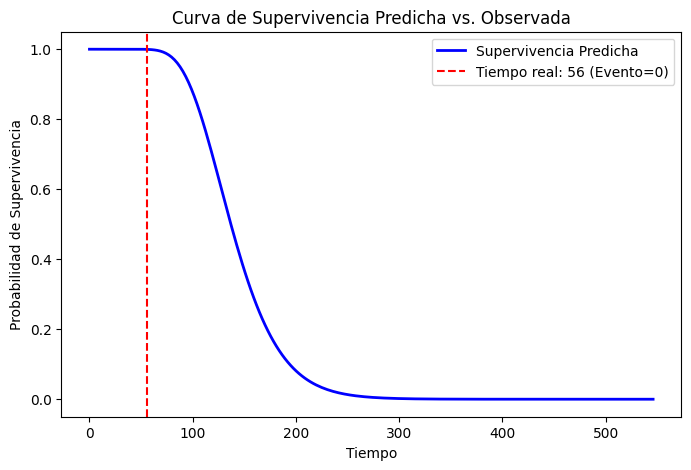

In [96]:
# ----------------------------------------------------------------------------
# 1. Dividir datos en entrenamiento y prueba
# ----------------------------------------------------------------------------
# Suponemos que 'data' es tu DataFrame con:
#   - 'dias_230': tiempo hasta el evento o censura
#   - 'E': 1 si el evento ocurrió, 0 si está censurado
#   - 'uso_230': variable predictora (puedes agregar más en la fórmula)

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# ----------------------------------------------------------------------------
# 2. Ajustar el modelo LogNormalAFTFitter en el set de entrenamiento
# ----------------------------------------------------------------------------
model = LogNormalAFTFitter()
model.fit(train_data, duration_col="dias_230", event_col="E", formula=formula_str)

# ----------------------------------------------------------------------------
# 4. Evaluar el modelo en el set de prueba
# ----------------------------------------------------------------------------
# 4.1. Cálculo de la mediana y la media predicha para cada individuo de prueba
pred_medians = model.predict_median(test_data)

# 4.2. Índice de concordancia (c-index)
c_index = concordance_index(test_data["dias_230"], -pred_medians, test_data["E"])
print(f"C-index en el set de prueba: {c_index:.3f}")

# ----------------------------------------------------------------------------
# 5. Mostrar una predicción particular
# ----------------------------------------------------------------------------
# Seleccionamos un individuo al azar del set de prueba
sample_subject = test_data.sample(5, random_state=1).copy()

# Info real
actual_time = sample_subject["dias_230"].values[0]
actual_event = sample_subject["E"].values[0]

# Calculamos su mediana y media de supervivencia
sample_subject["pred_median"] = model.predict_median(sample_subject)

# Mostramos la tabla comparativa
print("\nPredicción particular:")
print(sample_subject[["Medicion", "dias_230", "E", "uso_230", "pred_median"]])

# 5.1. Curva de supervivencia predicha
tiempos = np.linspace(0, max(actual_time, test_data["dias_230"].max()) + 50, 200)
sf_pred = model.predict_survival_function(sample_subject, times=tiempos)

plt.figure(figsize=(8,5))
plt.plot(tiempos, sf_pred.iloc[:, 0], label="Supervivencia Predicha", color="blue", linewidth=2)

# Marcamos el tiempo real de observación
plt.axvline(actual_time, color="red", linestyle="--", label=f"Tiempo real: {actual_time} (Evento={actual_event})")

plt.title("Curva de Supervivencia Predicha vs. Observada")
plt.xlabel("Tiempo")
plt.ylabel("Probabilidad de Supervivencia")
plt.legend()
plt.show()